In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd
import cvxpy as cp
import datetime
import matplotlib.pyplot as plt

# Bypass the "too many requests" error
yf.data.YfData.user_agent_headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36'
}

In [2]:
tickers = [ # ticker universe that contains the top market cap stocks
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "BRK-B", "WMT",
    "LLY", "JPM", "V", "MA", "UNH", "ORCL", "XOM", "TSM", "JNJ", "PG",
    "HD", "CVX", "KO", "PEP", "BAC", "MRK", "ABBV", "PFE", "CSCO", "ADBE",
    "NFLX", "NKE", "VZ", "INTC", "T", "CMCSA", "CRM", "ABT", "MCD", "DIS",
    "BABA", "TM", "SHEL", "NVS", "ASML", "AZN", "SNY", "LIN", "PM", "ACN",
    "TMO", "DHR", "COST", "WFC", "MS", "UPS", "BMY", "TXN", "NEE", "QCOM",
    "AMGN", "UL", "SAP", "UNP", "MDT", "HON", "INTU", "LOW", "SCHW",
    "RTX", "AMT", "SPGI", "GS", "BLK", "IBM", "PLD", "CVS", "DE", "SBUX",
    "BA", "CAT", "ELV", "NOW", "PYPL", "SHOP", "SONY", "MUFG", "HDB", "TD",
    "BP", "RIO", "OR", "ENB", "EQNR", "SREN.SW", "ZURN.SW", "ROG.SW", "GIVN.SW",
    "ADEN.SW", "NESN.SW", "UHR.SW", "CFR.SW", "RACE", "MBG.DE",
    "AIR.PA", "BAYN.DE", "BMW.DE", "DTE.DE", "DBK.DE", "SAN.PA", "OR.PA",
    "MC.PA", "BNP.PA", "SU.PA", "DG.PA", "ENGI.PA", "VIV.PA", "BARC.L",
    "LLOY.L", "GSK.L", "TSCO.L", "HSX.L", "VALE", "PBR", "BBDC4.SA", "ITUB4.SA",
    "WEGE3.SA", "ABEV", "BRFS3.SA", "MELI", "YPF", "ORSTED.CO",
    "NOVO-B.CO", "DSV.CO", "VWS.CO", "EQT", "DDOG", "SNOW", "PLTR", "TWLO", "SE", "BIDU",
    "NTES", "JD", "PDD", "XPEV", "NIO", "LI", "STLA", "MTX.DE",
    "SAP.DE", "VOW3.DE", "RWE.DE", "HEN3.DE", "IFX.DE", "BYDDY", "TCEHY", "NOK",
    "SPY", "VT", "GLD", "XLF", "XLV", "XLE", "QQQ", "IONQ", "XPH", "FSLR", "ENPH",
    "VWDRY", "CSIQ", "GXC", "CQQQ", "EL", "VERI", "ASTS", "CSSMI.SW"
]
tickers = sorted(tickers)

# Dictionary to store ticker-currency mappings
ticker_currencies = {}
scraped = {} # save the info for later in a dictionary to avoid asking yf again
for ticker in tickers:
    stock = yf.Ticker(ticker)
    scraped[ticker] = stock
    currency = stock.info.get("currency", None)  # Retrieve currency info
    ticker_currencies[ticker] = currency.upper()
    
currency_set = set(ticker_currencies.values())
currency_set.discard("CHF")
currency_tickers = ["CHF" + currency + "=X" for currency in currency_set]

The tickers are international, so we have to be careful to convert prices to CHF before computing returns. We can grab the currencies straight from `yfinance`.

The `data` variable stores the prices for every two days (we skip a day to reduce noise in the currency exchange and closing time differences between markets). Prices are adjusted to accound for dividend accrual. This means that they do not reflect the true historical price! The `returns` variable gives the percent change over 2 days. The currency exchanges are removed from `returns` and kept in `data`.

In [3]:
print("Downloading historical data...")
n_years = 5
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=n_years * 365)

# Download data for tickers and currency_tickers
data = yf.download(tickers + currency_tickers, start=start_date, end=end_date, interval="1d", progress=False)
data = data["Close"].dropna(how="all").ffill().dropna()

# Convert index to string format (YYYY-MM-DD)
data.index = pd.to_datetime(data.index).strftime("%Y-%m-%d")

for ticker in tickers:
    # Exchange currency if necessary
    currency = ticker_currencies[ticker]

    # Get dividends
    dividends = scraped[ticker].history(period="5y")["Dividends"]
    dividends.index = pd.to_datetime(dividends.index).strftime("%Y-%m-%d")
    dividends = dividends.reindex(data.index, fill_value=0)
    if currency == "GBP":
        dividends /= 100 # weird way to record in Britain

    data[ticker] += dividends.cumsum()
    
    if currency != "CHF":
        data[ticker] /= data["CHF" + currency + "=X"].values

data = data.iloc[::-2].iloc[::-1]
returns = np.log(data.drop(currency_tickers, axis=1)).diff().dropna()
print("Got the historical data!")
returns.head()


Got the historical data!


Ticker,AAPL,ABBV,ABEV,ABT,ACN,ADBE,ADEN.SW,AIR.PA,AMGN,AMT,...,WFC,WMT,XLE,XLF,XLV,XOM,XPEV,XPH,YPF,ZURN.SW
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-07,-0.004291,-0.001634,-0.026745,0.003972,0.016661,-0.020108,0.025089,0.001191,0.023511,-0.018254,...,0.087140,0.002552,0.041023,0.053935,0.022937,0.029408,0.057104,0.027578,0.030442,0.037850
2021-01-11,-0.004089,0.032256,0.000756,0.006698,-0.000047,0.003487,-0.005632,0.000176,0.025896,-0.001093,...,0.005140,0.015195,0.025204,0.013422,0.020296,0.051804,-0.003262,0.019229,-0.067461,-0.012719
2021-01-13,0.012737,0.029015,0.037778,0.009788,-0.007583,-0.006591,-0.007001,-0.007352,-0.001247,0.005178,...,0.014745,-0.000876,0.024544,0.007663,-0.010135,0.031213,0.150384,-0.005868,-0.079557,-0.012883
2021-01-15,-0.026419,0.010651,0.003457,0.003400,-0.010734,-0.027392,-0.013134,0.035769,0.034728,0.018371,...,-0.050826,-0.016592,-0.007822,-0.009558,0.002564,-0.008357,-0.074591,0.003208,-0.029652,-0.007437
2021-01-19,0.008392,0.017686,0.009478,0.014276,0.011545,-0.000476,-0.002716,-0.016660,0.014240,-0.010804,...,0.021226,-0.005701,0.022896,0.005562,0.010474,0.022622,0.121552,0.013171,-0.002084,-0.000800


Here we calculate the `market_caps` of each ticker and feed it through the covariance matrix to get the market's expected returns.

In [4]:
def get_market_cap(ticker):
    ticker_info = scraped[ticker].info
    
    # get marketCap
    currency = ticker_currencies[ticker]
    if currency == "CHF":
        conversion = 1
    else:
        conversion = data["CHF" + currency + "=X"].iloc[-1]
    cap_keys = ("marketCap", "totalAssets")
    for key in cap_keys:
        if key in ticker_info.keys():
            return ticker_info[key] / conversion
    
    if ticker == "ZGLD.SW":
        return 9e9
    return None

print("Getting market cap data...")
market_caps = pd.Series([get_market_cap(ticker) for ticker in tickers], index=tickers)
print("Got the market caps!")

Getting market cap data...
Got the market caps!


### Covariance calculation

Here, we use two techniques to calculate the covariance matrix.
- We weight more recent observations in `returns` more than the older ones when computing the basic covariance matrix
- Then, we use Ledoit-Wolf shrinkage to correct for overfitting. The target covariance matrix uses uniform correlation between all the stocks.

*Note, since the returns contain dividend payments, the dividends are accounded for through the covariance matrix only*

In [5]:
returns.index = pd.to_datetime(returns.index)
time_span = returns.index[-1] - returns.index[0]
n_years = time_span.days / 365
entries_per_year = len(returns) / n_years

# Calculate the covariance matrix based on weights that decrease exponentially with time
lamb = (1/n_years)**(1/n_years) # lambda in the exponential time weighting
weights = lamb**(np.array([(end_date - day).days for day in returns.index]) / 365)
weights /= np.sum(weights)
weighted_mean = (returns * weights[:, None]).sum()
weighted_cov = ((returns - weighted_mean) * weights[:, None]).T @ (returns - weighted_mean)
weighted_cov *= entries_per_year

# Estimate the correlation for Ledoit-Wolf shrinkage
delta = 0.2 # larger --> more shrinkage
standard_devs = np.sqrt(np.diag(weighted_cov))
weighted_corr = weighted_cov / standard_devs[None, :] / standard_devs[:, None]
average_corr = (np.sum(weighted_corr.values) - len(weighted_corr)) / len(weighted_corr) / (len(weighted_corr) - 1)
target_cov = np.full(weighted_cov.shape, average_corr)
np.fill_diagonal(target_cov, 1)
target_cov = pd.DataFrame(target_cov, index=weighted_cov.index, columns=weighted_cov.index)
target_cov = target_cov * standard_devs[None, :] * standard_devs[:, None]
sigma = delta * target_cov + (1 - delta) * weighted_cov # this is the empirical Sigma in the BL formulation

### Returns calculation

Our main tool will be the Black-Litterman model. Here, we assume that the market caps are weights used by the global economy, and we can calculate the expected returns by passing these weights through `sigma`.

From these expected returns, we update them based on our `views`. Our views incorporate `self.forces` (which measure the predicted Z score of the portfolio price given by `self.P`)

The final adjusted `expected_returns` will be used to optimize our portfolio by conditioning on a minimum total expected return.

In [6]:
# Market return
risk_aversion = 3.5 # higher means that investors require higher returns for a single unit of risk
pi = risk_aversion * sigma @ market_caps / market_caps.sum() # exess returns (after risk free + dividends)
pi = pi.squeeze()
oil_gas_tickers = ["BP", "CVX", "ENB", "EQNR", "PBR", "RIO", "SHEL", "VALE", "XOM", "XLE"]

one_hot = pd.DataFrame(np.eye(len(pi)), columns=pi.index) # Creates a a one-hot vector corresponding to each ticker to be fed to Views

class Views():
    def __init__(self, risk_free_rate=None):
        self.P = None
        self.forces = None
        self.expected_returns = None
        if risk_free_rate is None:
            # Fetch the 3-month Treasury Bill yield (^IRX)
            try:
                self.risk_free_rate = yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100 # Convert from a percent
            except:
                self.risk_free_rate = 0.04
        else:
            self.risk_free_rate = risk_free_rate

    def add_view(self, view, force):
        view = np.array(view)
        view = view.reshape(1, -1)
        if self.P is None:
            self.P = view
            self.forces = np.array(force, ndmin=1)
        else:
            self.P = np.vstack((self.P, view))
            self.forces = np.append(self.forces, force)

    def compute_returns(self, remove=None, verbose=False):
        if self.P is None:
            self.expected_returns = pi + self.risk_free_rate
        else:
            sigma_22 = self.P @ sigma.values @ self.P.T
            eigvals, eigvecs = np.linalg.eigh(sigma_22)
            assert np.all(eigvals > 0), "sigma_22 is not positive definite!"
            sqrt_sigma22_inv = eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T
            pi_adjusted = pi.values + (sigma.values @ self.P.T @ sqrt_sigma22_inv @ self.forces)

            if verbose and self.P is not None:
                print("Adjustments to the mean returns of the views:")
                print(eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T @ self.forces)

            expected_returns = self.risk_free_rate + pd.Series(pi_adjusted, pi.index)
            if remove is not None:
                expected_returns.loc[remove] = 0
            self.expected_returns = expected_returns
        return self.expected_returns

# Incorporate my views
views = Views()
views.add_view(one_hot["SPY"], -0.4)
views.add_view(one_hot["CSSMI.SW"], 0.2)
views.add_view(one_hot["META"], -0.05)
views.add_view((one_hot["NVDA"] + one_hot["AVGO"] + one_hot["TSM"])/3, 0.1)
views.add_view((2 * one_hot["IBM"] + one_hot["IONQ"])/3, 0.1) # Bullish on quantum, especially IBM
views.add_view(one_hot["CQQQ"] - one_hot["QQQ"], 0.1) # Bullish on China's ability to innovate
print(views.compute_returns(remove=oil_gas_tickers, verbose=True))

market = Views()
market.compute_returns(remove=oil_gas_tickers)

boom = Views(risk_free_rate=0.05)
boom.add_view(one_hot["SPY"], 2)
boom.add_view(one_hot["GXC"], 2)
boom.add_view(one_hot["CSSMI.SW"], 2)
boom.compute_returns(remove=oil_gas_tickers, verbose=True)

crash = Views(risk_free_rate=0)
crash.add_view(one_hot["SPY"], -2) # 2 standard deviations away from equilibrium
crash.add_view(one_hot["GXC"], -2)
crash.add_view(one_hot["CSSMI.SW"], -2)
crash.compute_returns(remove=oil_gas_tickers, verbose=True)

Adjustments to the mean returns of the views:
[-0.04714536  0.02037494 -0.02808156  0.01057037  0.02433955  0.04122285]
Ticker
AAPL       0.158095
ABBV       0.083297
ABEV       0.112869
ABT        0.088874
ACN        0.131440
             ...   
XOM        0.000000
XPEV       0.267502
XPH        0.111911
YPF        0.189619
ZURN.SW    0.093997
Length: 177, dtype: float64
Adjustments to the mean returns of the views:
[0.530282   0.72883301 0.39151514]
Adjustments to the mean returns of the views:
[-0.530282   -0.72883301 -0.39151514]


Ticker
AAPL      -0.450175
ABBV      -0.243353
ABEV      -0.352737
ABT       -0.257822
ACN       -0.371734
             ...   
XOM        0.000000
XPEV      -0.971053
XPH       -0.334341
YPF       -0.630950
ZURN.SW   -0.266416
Length: 177, dtype: float64

In [7]:
ticker = "SPY"
print(views.expected_returns[ticker].item())
print(market.expected_returns[ticker].item())
print(boom.expected_returns[ticker].item())
print(crash.expected_returns[ticker].item())

0.11314435947999596
0.1602897216073096
0.6984417225757529
-0.41212227577531824


### Simulate more data

Our optimization strategy will involve calculating extreme losses. Due to the limited historical data, we simulate extra data by linearly transforming independent Student-T prices to have covariance `sigma`.

In [8]:

L = np.linalg.cholesky(sigma / entries_per_year)
def simulate_year(views, df_student):
    if views.expected_returns is None:
        views.compute_returns(remove=oil_gas_tickers)
    # Set parameters
    sim_historic_ratio = entries_per_year # infinity
    
    n_total = int(entries_per_year)
    n_sample = int(entries_per_year / (sim_historic_ratio + 1))
    n_sim = n_total - n_sample

    simulated_returns = stats.t.rvs(df=df_student, size=(n_sim, len(returns.columns)))  # Standard-t
    simulated_returns /= np.sqrt(df_student / (df_student - 2)) # Normalize to unit variance
    assert sigma.columns is returns.columns, "Non-matching columns"
    simulated_returns = pd.DataFrame(simulated_returns @ L.T, columns=returns.columns)
    
    dates = np.random.choice(returns.index, size=n_sample, replace=True, p=weights)
    return returns.loc[dates].sum(axis=0) + simulated_returns.sum(axis=0) + n_sim * views.expected_returns / entries_per_year


years_per_scenario = 3000
scenarios = [views, market, boom, crash]
probabilities = np.array([4, 1, 1, 1])
dfs = [5, 5, 4, 3]
probabilities = probabilities / np.sum(probabilities)
annual_returns = [pd.concat([simulate_year(scenario, df_student) for _ in range(years_per_scenario)], axis = 1).T for scenario, df_student in zip(scenarios, dfs)]

### Portfolio optimization

The function `optimal_portfolio(...)` computes the portfolio weights that correspond to the minimum `desired_returns`, minimizing the vulnerability of the portfolio to extreme shocks.

In [9]:
n_scenarios = len(scenarios)
n_assets = len(annual_returns[0].columns)

def optimal_portfolio(desired_returns,
                      verbose=False,
                      partial_weights=None,
                      alpha=0.95,
                      min_weight=1e-5):
    """
    This function computes the weights of the portfolio that is optimized for the
    global `scenarios` variable, with associated `probabilities` and `dfs`.

    Parameters:
        - desired_returns (float): The minimum expected returns of the portfolio across
        all scenarios, weighted by the probabilities. If it is not possible to
        cunstruct such a portfolio, the function throws an AssertionError.
        - verbose (bool): Print additional information and plot the portfolio's history.
        - partial_weights (pd.Series): The minimum portfolio weights in the resulting
        portfolio. Requires partial_weights.sum() < 1.
        - alpha (float): The quantile at which the value at risk (VaR) is computed.
        - min_weight (float): Stocks that are assigned weights less than this value are
        excluded from the portfolio.

    Returns a dictionary containing:
        - "VaR" : the value at risk at the spec,
        - "ES" : a vector of expected shortfalls in each scenario,
        - "Quantile" : alpha,
        - "Returns" : the expected returns of the portfolio. This might be less than
        desired_returns if min_weights > 0.
        - "Weights" : The portfolio weights.
        - "Risk" : The maximum weighted risk measure (expected shortfall weighted by
        by probabilities) across all scenarios.
    """
    
    if partial_weights is None:
        partial_weights = 0
        partial_weight_amount = 0
    else:
        assert partial_weights.sum() < 1, "Invalid partial_weights."
        partial_weights = partial_weights.values
        partial_weight_amount = np.sum(partial_weights)

    # Define CVXPY variables.
    w = cp.Variable(n_assets) # portfolio weights
    nu = cp.reshape(cp.Variable(n_scenarios), (n_scenarios, 1), order='C') # VaR at level alpha (to be determined)
    xi = cp.Variable((n_scenarios, years_per_scenario)) # auxiliary variables for the losses beyond VaR
    losses = cp.vstack([- ret.values @ (w + partial_weights) for ret in annual_returns]) # one loss for each scenario
    expected_returns = [scenario.compute_returns(remove=oil_gas_tickers) * probabilities[i] for i, scenario in enumerate(scenarios)]
    expected_returns = pd.concat(expected_returns, axis=1).sum(axis=1) # already probability weighted
    expected_shortfall = nu + (1/(1-alpha))*(1/years_per_scenario)*cp.reshape(cp.sum(xi, axis=1), (n_scenarios, 1), order='C')
    weighted_risk_measures = cp.multiply(probabilities.reshape((n_scenarios, 1)), expected_shortfall)

    max_weighted_risk_measure = cp.Variable()

    # Constraints for CVaR:
    constraints = [
        xi >= losses - nu,                               # each xi >= loss_i - nu
        xi >= 0,                                         # slack variables non-negative
        cp.sum(w) == 1 - partial_weight_amount,          # full (complementary) investment
        w >= 0,                                          # long-only constraint
        # expected annual constraint
        expected_returns.values @ (w + partial_weights) >= desired_returns,  
        max_weighted_risk_measure >= weighted_risk_measures
    ]

    objective = cp.Minimize(max_weighted_risk_measure)
    problem = cp.Problem(objective, constraints)

    # Solve optimization
    problem.solve(solver=cp.ECOS)
    assert w.value is not None, "No solution!"
    optimized_weights = pd.Series(w.value + partial_weights, index=expected_returns.index)
    optimized_weights[optimized_weights < min_weight] = 0
    optimized_weights /= optimized_weights.sum()
    optimized_returns = np.dot(expected_returns.values, optimized_weights.values)

    if(verbose):
        print(f"Quantile: {alpha:.3f}")
        print(f"VaR:")
        print(nu.value)
        print(f"ES:")
        print(expected_shortfall.value)
        print(f"Total returns: {optimized_returns:.4f}")
        print(f"Portfolio risk: {max_weighted_risk_measure.value:.4f}")
        print("---")
        print(optimized_weights[optimized_weights > 0])
        portfolio_history = data[expected_returns.index].values @ optimized_weights.values
        portfolio_history = pd.Series(portfolio_history, pd.to_datetime(data.index))
        plt.plot(portfolio_history / portfolio_history.iloc[0])
        plt.title("Portfolio history")
        plt.xlabel("Date")
        plt.ylabel("Cumulative returns")
    return({"VaR" : nu.value,
            "ES" : expected_shortfall,
            "Quantile" : alpha,
            "Returns" : optimized_returns,
            "Weights" : optimized_weights,
            "Risk" : max_weighted_risk_measure})


In [10]:
def get_last_price(ticker):
    ticker_info = scraped[ticker].info
    
    # get last price
    currency = ticker_currencies[ticker]
    if currency == "CHF":
        conversion = 1
    else:
        conversion = data["CHF" + currency + "=X"].iloc[-1]
    return ticker_info["previousClose"] / conversion
    return None

In [11]:

positions = {
    "AVGO" : 3,
    "CSSMI.SW" : 2,
    "DTE.DE" : 25,
    "ENGI.PA" : 30,
    "GLD" : 4,
    "GOOGL" : 1,
    "HEN3.DE" : 4,
    "IONQ" : 14,
    "NESN.SW" : 21,
    "NIO" : 190,
    "NVDA" : 1,
    "SAP.DE" : 1,
    "SREN.SW" : 4,
    "TSCO.L" : 0.8,
    "UNH" : 1,
    "ZURN.SW" : 1
}
positions = pd.DataFrame(list(positions.items()), columns=['Ticker', 'Position'])
positions['Price'] = positions['Ticker'].apply(get_last_price)
positions['Value'] = positions['Position'] * positions['Price']
# desired_returns = market.expected_returns["SPY"]

net_value = np.sum(positions['Value']) + 5000 # CHF. Cash + stocks
partial_weights = pd.Series(0, index=tickers)
for index, row in positions.iterrows():
    partial_weights[row['Ticker']] = row['Value'] / net_value
    
desired_returns = 0.14

C:\Users\rcotsaki\AppData\Local\Temp\ipykernel_16860\3095304149.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0325000134318473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  partial_weights[row['Ticker']] = row['Value'] / net_value


Quantile: 0.950
VaR:
[[ 0.11234454]
 [ 0.04344538]
 [-0.44406272]
 [ 0.61936172]]
ES:
[[0.18046333]
 [0.72153024]
 [0.72075377]
 [0.72184294]]
Total returns: 0.1393
Portfolio risk: 0.1031
---
Ticker
AMZN        0.054109
AVGO        0.078157
BMW.DE      0.064051
CFR.SW      0.007167
CSSMI.SW    0.039973
DSV.CO      0.006212
DTE.DE      0.057248
ENGI.PA     0.038932
GIVN.SW     0.008651
GLD         0.074273
GOOGL       0.009706
HDB         0.018264
HEN3.DE     0.019562
IONQ        0.023021
NESN.SW     0.137983
NIO         0.039582
NVDA        0.075829
ORCL        0.006979
ROG.SW      0.050673
SAP.DE      0.016614
SREN.SW     0.043399
TSCO.L      0.020947
TSM         0.027362
UNH         0.037753
ZURN.SW     0.043555
dtype: float64


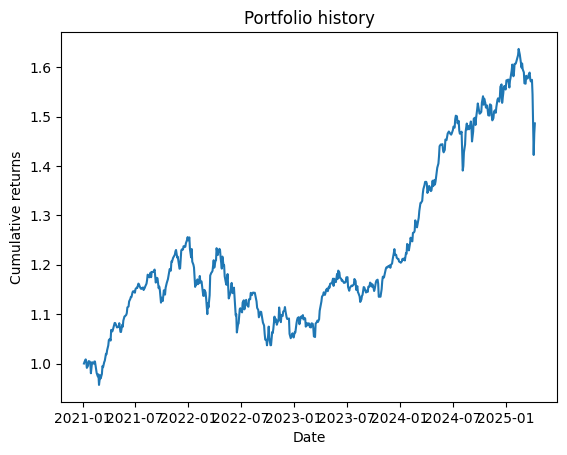

In [12]:
my_portfolio = optimal_portfolio(desired_returns,
                                 verbose=True,
                                 partial_weights=partial_weights,
                                 min_weight=5e-3)

In [13]:
# Let's calculate how many shares to buy.
last_prices = pd.Series([get_last_price(ticker) for ticker in tickers], tickers)
n_shares = net_value * my_portfolio["Weights"] / last_prices
print(n_shares[n_shares > 0])


Ticker
AMZN          4.748787
AVGO          7.214467
BMW.DE       13.758721
CFR.SW        0.684218
CSSMI.SW      4.435418
DSV.CO        0.569417
DTE.DE       25.253998
ENGI.PA      30.304798
GIVN.SW       0.030568
GLD           4.040640
GOOGL         1.010160
HDB           4.466985
HEN3.DE       4.040640
IONQ         14.142239
NESN.SW      21.213359
NIO         191.930388
NVDA         11.211524
ORCL          0.832441
ROG.SW        2.702594
SAP.DE        1.010160
SREN.SW       4.040640
TSCO.L        0.808128
TSM           2.879509
UNH           1.010160
ZURN.SW       1.010160
dtype: float64


In [ ]:
# Plotting
returns_seq = np.arange(0.06, 0.17, 0.01)
risk_seq = [optimal_portfolio(r)["Risk"].value for r in returns_seq]

# Plot both lines
plt.figure(figsize=(8, 5))
plt.plot(returns_seq, risk_seq, label="Risk", linestyle='-', marker='o')

# Labels and Title
plt.xlabel("Target Return")
plt.ylabel(f"Maximum weighted portfolio risk")
plt.title("CVaR Optimization")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
ticker = "SPY"
data.index = pd.to_datetime(data.index)
plt.plot(data[ticker] / data[ticker].iloc[0])
plt.xlabel("Date")
plt.ylabel("Cumulative returns")
plt.title(ticker)
plt.show()

Here is some code to calculate the `risk aversion` parameter.

```python
def estimate_risk_aversion():
    """
    Estimate the Black-Litterman risk aversion coefficient (lambda)
    based on market conditions.
    
    Uses:
    - VIX (volatility index)
    - 10-year Treasury Yield (^TNX)
    - S&P 500 drawdown (SPY)

    Returns:
        float: Estimated risk aversion coefficient (lambda)
    """
    
    # Fetch market data
    vix = yf.Ticker("^VIX").history(period="1d")["Close"].iloc[-1]  # Market volatility
    tnx = yf.Ticker("^TNX").history(period="1d")["Close"].iloc[-1] / 100  # Convert from % to decimal
    spy = yf.Ticker("SPY").history(period="6mo")["Close"]  # S&P 500 ETF
    
    # Compute max drawdown over the last 6 months
    max_price = spy.max()
    current_price = spy.iloc[-1]
    drawdown = (max_price - current_price) / max_price  # Drawdown as a fraction
    
    # Baseline risk aversion
    lambda_base = 3.5  # Normal market
    
    # Adjust for VIX (higher VIX → higher lambda)
    if vix < 15:  # Low volatility
        lambda_vix = 3.0
    elif 15 <= vix < 25:  # Normal volatility
        lambda_vix = 3.5
    elif 25 <= vix < 35:  # High volatility
        lambda_vix = 4.5
    else:  # Very high volatility (panic)
        lambda_vix = 5.5
    
    # Adjust for interest rates (higher rates → higher lambda)
    if tnx < 0.02:  # Very low rates
        lambda_tnx = 3.0
    elif 0.02 <= tnx < 0.04:  # Moderate rates
        lambda_tnx = 3.5
    else:  # High rates
        lambda_tnx = 4.5
    
    # Adjust for drawdown (larger drawdown → higher lambda)
    if drawdown < 0.05:  # No major downturn
        lambda_dd = 3.0
    elif 0.05 <= drawdown < 0.10:  # Mild downturn
        lambda_dd = 4.0
    elif 0.10 <= drawdown < 0.20:  # Market correction
        lambda_dd = 5.0
    else:  # Bear market
        lambda_dd = 6.0

    # Weighted average of the different risk aversion factors
    lambda_final = np.mean([lambda_base, lambda_vix, lambda_tnx, lambda_dd])

    print(f"Estimated risk aversion coefficient (lambda): {lambda_final:.2f}")
    return lambda_final

# Run the function to estimate lambda dynamically
lambda_dynamic = estimate_risk_aversion()
```
